# Добрый день!

Меня зовут Алексей. Я рад представить вам свою версию решения поставленной задачи

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, cohen_kappa_score

# Определение дефолта

Выполняя задание, я понял, что мне необходимо хотя бы минимально вникнуть в доменную область, поэтому пошел читать тематические статьи

Кратко говоря, дефолт - это невозможность больше выполнять долговые обязательства

Часто дефолт является отправной точкой к банкротству компании и ее упразднению, но это ни в коем случае не одно и то же

Отталкиваясь от этого определения дефолта, далее я старался подбирать такие признаки, которые помогли бы компании, если что, справиться с выплатой долгов

# 1. Data preprocessing

Для начала, очевидно, загрузим датасеты

In [2]:
def load_data():
  !wget https://raw.githubusercontent.com/BKHV/risk_models/master/data/PD-data-train.csv
  !wget https://raw.githubusercontent.com/BKHV/risk_models/master/data/PD-data-test.csv
  !wget https://raw.githubusercontent.com/BKHV/risk_models/master/data/PD-data-desc.csv

  train_df = pd.read_csv('PD-data-train.csv', sep=';')
  test_df = pd.read_csv('PD-data-test.csv', sep=';')
  desc_df = pd.read_csv('PD-data-desc.csv', sep=';')

  return train_df, test_df, desc_df


In [3]:
train_df, test_df, desc_df = load_data()

--2022-03-29 06:33:00--  https://raw.githubusercontent.com/BKHV/risk_models/master/data/PD-data-train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5329268 (5.1M) [text/plain]
Saving to: ‘PD-data-train.csv’

PD-data-train.csv   100%[===================>]   5.08M  --.-KB/s    in 0.08s   

2022-03-29 06:33:00 (65.5 MB/s) - ‘PD-data-train.csv’ saved [5329268/5329268]

--2022-03-29 06:33:00--  https://raw.githubusercontent.com/BKHV/risk_models/master/data/PD-data-test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28259 (28

Сохраним названия категориальных и непревных фичей в отдельные массивы


In [4]:
def save_features_by_type(dataset):
  cat = ["ul_strategic_flg", "ul_systematizing_flg", "ul_staff_range"]
  cont = []
  TARGET = "default_12m"

  for feature in list(dataset):
    if feature not in cat and feature != TARGET:
      cont.append(feature)
  
  return cont, cat, TARGET


cont_features, cat_features, TARGET = save_features_by_type(train_df)

Функция для удобного вывода описания признаков

In [ ]:
def rus_by_eng(*features, field=True):
  for value in features:
    if field:
      print(value, '—', desc_df[desc_df.field==value].desc_rus.values)
    else:
      print(value, '—', desc_df[desc_df.desc_eng==value].desc_rus.values)

### Обработаем категориальный признак ul_staff_range




Изначально в ul_staff_range имеется три значения: штат до ста человек, штат от ста до пятисот человек и штат более пятисот человек

Таким образом, я неявно разделил компании на три типа по виду штата: маленькие, средние и огромные

Предположив, что в компаниях каждого вида работает +- одинаковое количество человек, сделал такую замену, отталкиваясь от распределения частот трех типов компаний

In [ ]:
values = {"[1-100]": 10, "(100-500]": 100, "> 500": 800}
train_df.ul_staff_range = train_df.ul_staff_range.replace(values)
test_df.ul_staff_range = test_df.ul_staff_range.replace(values)

Можно убедиться, что теперь в компаниях каждого вида работает примерно одинаковое количество людей

In [ ]:
print("В маленьких компаниях работают:", train_df.ul_staff_range.value_counts().values[0] * 10, "человек")
print("В средних компаниях работают:", train_df.ul_staff_range.value_counts().values[1] * 100, "человек")
print("В огромных компаниях работают:", train_df.ul_staff_range.value_counts().values[2] * 800, "человек")

В маленьких компаниях работают: 292810 человек
В средних компаниях работают: 275700 человек
В огромных компаниях работают: 285600 человек


### Заполним пропуски

В данных есть пропуски. Причем они расположены так, что у N компаний есть пропуски в M одинаковых признаках

Убедимся в этом:



In [ ]:
assert train_df.isna().sum()[1] == train_df.shape[0] - train_df.dropna().shape[0]

Запомним названия фичей, в которых есть пропуски



In [ ]:
def find_missed_features(dataset):
  mask = dataset.isna().sum() != 0
  missed_features = []
  try:
    for flag, feature in zip(mask, list(dataset.drop("default_12m", axis=1))):
      if flag:
        missed_features.append(feature)
  except KeyError:
    for flag, feature in zip(mask, list(dataset)):
      if flag:
        missed_features.append(feature)
  
  return missed_features

В train и test датасетах пропущены одни и те же фичи, поэтому найдем пропуски в train_df (это не принципиально) и будем использовать их

In [ ]:
if find_missed_features(train_df) == find_missed_features(test_df):
  missed_features = find_missed_features(train_df)
else:
  print("THERE ARE DIFFERENT COLLECTIONS OF MISSED FEATURES")

Взглянем на фичи, в которых есть пропуски

In [ ]:
rus_by_eng(*missed_features)

ar_revenue — ['Выручка от реализации (на конец последнего года)']
ar_total_expenses — ['Общие расходы за последний год']
ar_sale_cost — ['Себестоимость продаж (на конец последнего года)']
ar_selling_expenses — ['Коммерческие расходы (на конец последнего года)']
ar_management_expenses — ['Управленческие расходы (на конец последнего года)']
ar_sale_profit — ['Прибыль от реализации (на конец последнего года)']
ar_balance_of_rvns_and_expns — ['Баланс доходов и расходов (на конец последнего года)']
ar_profit_before_tax — ['Валовая прибыль (на конец последнего года)']
ar_taxes — ['Текущий на налог на прибыль (на конец последнего года)']
ar_other_profit_and_losses — ['Прочие доходы и расходы (на конец последнего года)']
ar_net_profit — ['Чистая прибыль (на конец последнего года)']
ab_immobilized_assets — ['Основные внеоборотные средства за последний год']
ab_mobile_current_assets — ['Оборотные активы (на конец последнего года)']
ab_inventory — ['Запасы (на конец последнего года)']
ab_accounts

Отдельно запомню категориальные и непрерывные фичи, в которых нужно заполнить пропуски, т.к. дискретные я планирую заполнить модами, а непрерывные медианами

In [ ]:
cat_features_to_fill = list(filter(lambda x: x in missed_features, cat_features))
cont_features_to_fill = list(filter(lambda x: x in missed_features, cont_features))

if not cat_features_to_fill:
  print("Пропусков в категориальных фичах нет!")
if not cont_features_to_fill:
  print("Пропусков в непрерывных фичах нет!")

Пропусков в категориальных фичах нет!


Оказывается, пропуски есть лишь в непрерывных фичах

Я не хочу заполнять пропуски медианами по всем векторам фичей

Условно я поделил компании на три типа по размеру штата

Для каждой компании, которая имеет пропуски, я буду заполнять их медианами по компаниям с таким же типом штата

Для каждой из категории штатов запомним медианное значение непрерывных фичей, которые нужно заполнить

Мы знаем, что у нас всего 3 типа компаний по штату, так что это можно захардкодить, но я решил написать функцию для нахождения медианных значений пропущенных фичей по каждому типу штата отдельно (которая все равно хардкодит, ахахаххаа)

In [ ]:
def find_medians_by_staff(dataset):
  medians = []
  unique_staff_values = dataset.ul_staff_range.unique()
  for value in np.sort(unique_staff_values):
    type_medians = dataset[dataset.ul_staff_range == value][cont_features_to_fill].median()
    medians.append(type_medians)
  
  return medians

 Функция, которая красиво заполнит пропуски в наших датасетах

In [ ]:
def fill_missed_values_by_staff(dataset):
  median_types = find_medians_by_staff(dataset)
  staff_quant = [10, 100, 800]

  for staff, quantity  in zip(median_types, staff_quant):
    for feature, median in zip(staff.index, staff.values):
      dataset[dataset.ul_staff_range == quantity] = dataset[dataset.ul_staff_range == quantity].replace({feature: np.nan}, median)
  
  return dataset

Заполним пропуски в train_df и сделаем проверку на то, что их больше нет

In [ ]:
train_df = fill_missed_values_by_staff(train_df)

assert train_df.isna().sum().sum() == 0

Аналогично заполним фичи в test_df и сделаем проверку на то, что в датасете больше нет ячеек с пропусками

In [ ]:
test_df = fill_missed_values_by_staff(test_df)

assert test_df.isna().sum().sum() == 0

### Выделим малоинформативные фичи


Заметим, что некоторые векторы фичей содержат очень много нулей

Из-за дисбаланса значений в этих признаках, они зачастую не являются сильно информативными


Например, признаки adr_actual_age и head_actual_age абсолютно одинаковы

Удалим одну из колонок, чтобы понизить размерность

In [ ]:
assert (train_df.adr_actual_age == train_df.head_actual_age).sum() / len(train_df) == 1
assert (test_df.adr_actual_age == test_df.head_actual_age).sum() / len(test_df) == 1

In [ ]:
train_df = train_df.drop("head_actual_age", axis=1)
test_df = test_df.drop("head_actual_age", axis=1)
cont_features.remove("head_actual_age")

Посмотрим на количество ноль-значений в датасетах

Для этого установим порог, который мы считаем неинформативным - он будет равен части нулевых значений в векторе значений фичи



In [ ]:
def find_lowinf_features(dataset, thresh=0.95):
  useless = []

  for feature in list(dataset):
    if feature in cont_features:
      if (dataset[feature] == 0).sum() / len(dataset) >= thresh:
        useless.append(feature)

    elif feature in cat_features and feature != "ul_staff_range":
      if dataset[feature].mean() <= (1 - thresh):
        useless.append(feature)
  
  return useless

In [ ]:
train_useless = find_lowinf_features(train_df)
test_useless = find_lowinf_features(test_df)

In [ ]:
print("Малоинформативных признаков в train_df:", len(train_useless))
print("Малоинформативных признаков в test_df:", len(test_useless))

Малоинформативных признаков в train_df: 5
Малоинформативных признаков в test_df: 7


Взглянем, что за неинформативные признаки на примере train_df

In [ ]:
for feature in train_useless:
  rus_by_eng(feature)
  if feature in cont_features:
    print(f"Процент нулей: {(train_df[feature] == 0).sum() / len(train_df)}")
  if feature in cat_features:
    print(f"Баланс значений: {train_df[feature].mean()}")

ar_management_expenses — ['Управленческие расходы (на конец последнего года)']
Процент нулей: 0.9570921438493595
ar_other_profit_and_losses — ['Прочие доходы и расходы (на конец последнего года)']
Процент нулей: 0.9532643926531872
ul_branch_cnt — ['Количество филиалов']
Процент нулей: 0.9899984565519371
ul_strategic_flg — ['Компания стратегического значения']
Баланс значений: 9.260688377836085e-05
ul_systematizing_flg — ['Системообразующая компания']
Баланс значений: 0.0


Сохраним список информативных из фичей, убрав из них список train_useless

Убираем именно из train_useless, чтобы в train и test датасетах сохранились одинаковые признаки



In [ ]:
inf_features = list(filter(lambda x: x not in train_useless and x not in ["record_id", "default_12m"],
                          list(train_df)))


Не забудем обновить значения в массивах cont_features и cat_features


In [ ]:
cont_features = list(filter(lambda x: x not in train_useless, cont_features))
cat_features = list(filter(lambda x: x not in train_useless, cat_features))

assert len(cat_features) + len(cont_features) == 30

# 2. Боремся с дизбалансом классов

Не все алгоритмы машинного обучения плохо работают с дизбалансом классов, однако, мои попытки без борьбы с ним оказывались очень плохи. А делать crop_balance (метод описан ниже) достаточно опасно, так как алгоритмы типа рандомного леса могут перееобучаться из-за относительно небольшого количества данных

Насколько я знаю, линейные модели могут неплохо работать с "небольшим" числом данных, однако, результат на контесте они также показали слабый

### Функции для синтетической балансировки

Балансировка с помощью копирования данных о компаниях, которые были подвержены дефолту

In [ ]:
def upsample_balance(dataset, rat=12):
  upsamled_df = dataset.loc[dataset['default_12m']==1]
  upsamled_df = upsamled_df.loc[upsamled_df.index.repeat(rat)]
  dataset = pd.concat([dataset.loc[dataset['default_12m']==0], upsamled_df]).sample(frac=1)

  return dataset

Балансировка с помощью удаления строк с доминирующей целевой переменной

In [ ]:
def crop_balance(dataset):
  good_proportion = (25496, 2368, 336)
  dataset[(dataset.ul_staff_range == 10) & (dataset.default_12m == 0)] = dataset[(dataset.ul_staff_range == 10) & (dataset.default_12m == 0)].iloc[:1769]
  dataset[(dataset.ul_staff_range == 100) & (dataset.default_12m == 0)] = dataset[(dataset.ul_staff_range == 100) & (dataset.default_12m == 0)].iloc[:321]
  dataset[(dataset.ul_staff_range == 800) & (dataset.default_12m == 0)] = dataset[(dataset.ul_staff_range == 800) & (dataset.default_12m == 0)].iloc[:14]

  dataset = dataset.dropna()
  return dataset

 Сделаем upsampling для train_df и будем обучать модели на нем. Также сохраним исходный датафрейм в unbalanced_df, чтобы суметь переписывать train_df, меняя пропорции балансировки, по ходу работы

In [ ]:
unbalanced_train_df = train_df.copy()
train_df = upsample_balance(train_df)

#3. Feature exploring






In [ ]:
rus_by_eng(*list(train_df))

record_id — []
ar_revenue — ['Выручка от реализации (на конец последнего года)']
ar_total_expenses — ['Общие расходы за последний год']
ar_sale_cost — ['Себестоимость продаж (на конец последнего года)']
ar_selling_expenses — ['Коммерческие расходы (на конец последнего года)']
ar_management_expenses — ['Управленческие расходы (на конец последнего года)']
ar_sale_profit — ['Прибыль от реализации (на конец последнего года)']
ar_balance_of_rvns_and_expns — ['Баланс доходов и расходов (на конец последнего года)']
ar_profit_before_tax — ['Валовая прибыль (на конец последнего года)']
ar_taxes — ['Текущий на налог на прибыль (на конец последнего года)']
ar_other_profit_and_losses — ['Прочие доходы и расходы (на конец последнего года)']
ar_net_profit — ['Чистая прибыль (на конец последнего года)']
ab_immobilized_assets — ['Основные внеоборотные средства за последний год']
ab_mobile_current_assets — ['Оборотные активы (на конец последнего года)']
ab_inventory — ['Запасы (на конец последнего года

Посмотрим на зависимость вероятности столкнуться с дефолтом в зависимости от определенных значений различных непрерывных переменных в данных


In [ ]:
thresh = 5

print(f"Вероятность дефолта у компаний, которые вели бизнес не меньше {thresh} лет:", round(train_df[train_df["bus_age"] >= thresh].default_12m.mean(), 3))
print(f"Вероятность дефолта у компаний, которые вели бизнес меньше {thresh} лет:", round(train_df[train_df["bus_age"] < thresh].default_12m.mean(), 3))

Вероятность дефолта у компаний, которые вели бизнес не меньше 5 лет: 0.449
Вероятность дефолта у компаний, которые вели бизнес меньше 5 лет: 0.721


Выходит, что среди компаний, которые ведут бизнес больше пяти лет, априорная вероятность дефолта снижается почти втрое

In [ ]:
m = train_df.ul_capital_sum.mean()
s = train_df.ul_capital_sum.std()

print(f"Вероятность дефолта у компаний, капитал которых не меньше среднего по датафрейму:", round(train_df[train_df["ul_capital_sum"] >= m].default_12m.mean(), 3))
print(f"Вероятность дефолта у компаний, капитал которых меньше среднего по датафрейму:", round(train_df[train_df["ul_capital_sum"] < m].default_12m.mean(), 3))
print("Вероятности с учетом одного стандартного отклонения:")
print(round(train_df[train_df["ul_capital_sum"] >= m + s].default_12m.mean(), 3))
print(round(train_df[train_df["ul_capital_sum"] < m + s].default_12m.mean(), 3))

Вероятность дефолта у компаний, капитал которых не меньше среднего по датафрейму: 0.294
Вероятность дефолта у компаний, капитал которых меньше среднего по датафрейму: 0.464
Вероятности с учетом одного стандартного отклонения:
0.137
0.457


Для фичи "Величина капитала": очевиден факт, что в наших данных компании с большим уставным капиталом реже подвержены дефолту

In [ ]:
m = train_df.ul_founders_cnt.mean()
s = train_df.ul_founders_cnt.std()

print(f"Вероятность дефолта у компаний, количество акционеров у которых не меньше среднего по датафрейму:", round(train_df[train_df["ul_founders_cnt"] >= m].default_12m.mean(), 3))
print(f"Вероятность дефолта у компаний, количество акционеров у которых меньше среднего по датафрейму:", round(train_df[train_df["ul_founders_cnt"] < m].default_12m.mean(), 3))

Вероятность дефолта у компаний, количество акционеров у которых не меньше среднего по датафрейму: 0.204
Вероятность дефолта у компаний, количество акционеров у которых меньше среднего по датафрейму: 0.461


От количества акционеров априорная вероятность дефолта в наших данных тоже зависит


Все эти размышления навели меня на мысль о том, что круто было бы сделать график, по оси абсцисс которого откладываются значения какой-либо фичи, а по оси ординат процент компаний, которые были подвержены дефолту, имея показатель по этому признаку не меньше значения на оси абсцисс

In [ ]:
def show_default_probs(feature):
  if feature == "record_id":
    return None
  thresholds = np.linspace(train_df[feature].min(), train_df[feature].max() - 1, 1000)
  probs = np.array([train_df[train_df[feature] >= thresh].default_12m.mean() for thresh in thresholds])
  plt.rcParams["figure.figsize"] = (16, 8)
  plt.plot(thresholds, probs, color="r")
  name = desc_df[desc_df.field == feature].desc_rus
  plt.xlabel(f"{feature} values")
  plt.ylabel("Default probability")
  plt.title(f"Dependence a default probability from '{name.values[0]}'")
  plt.show()
  

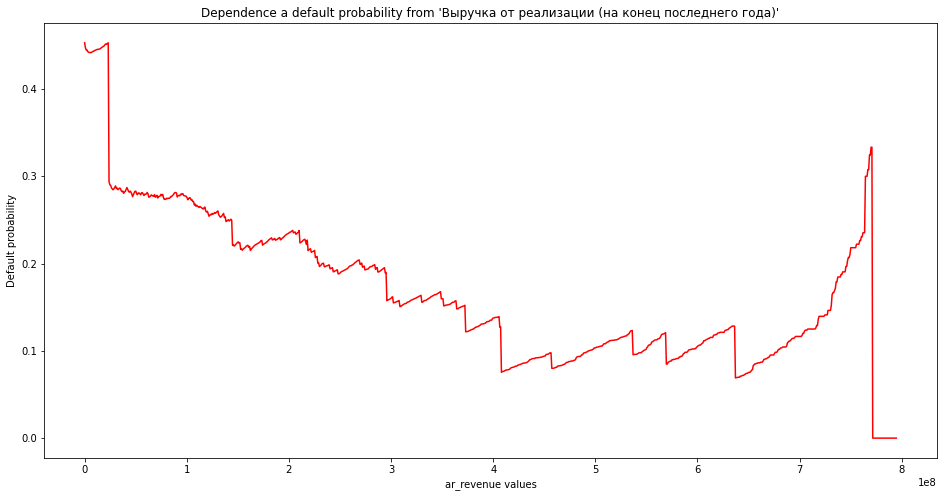

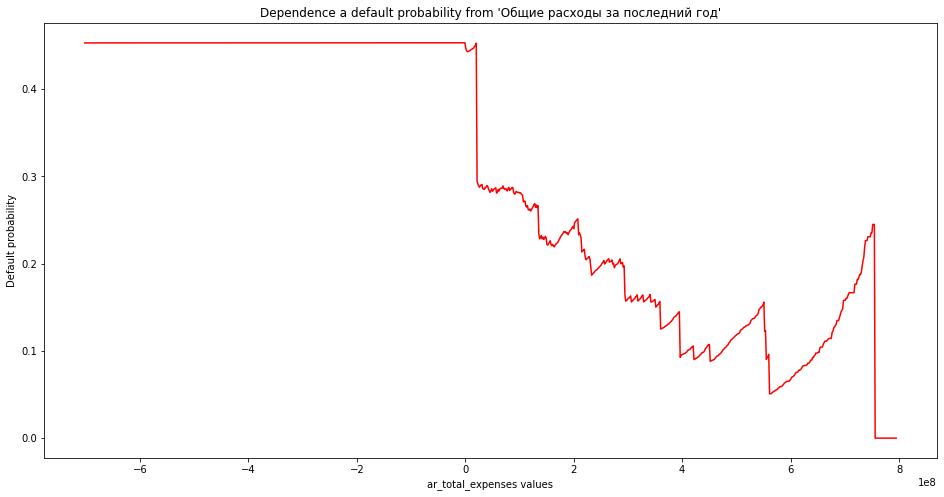

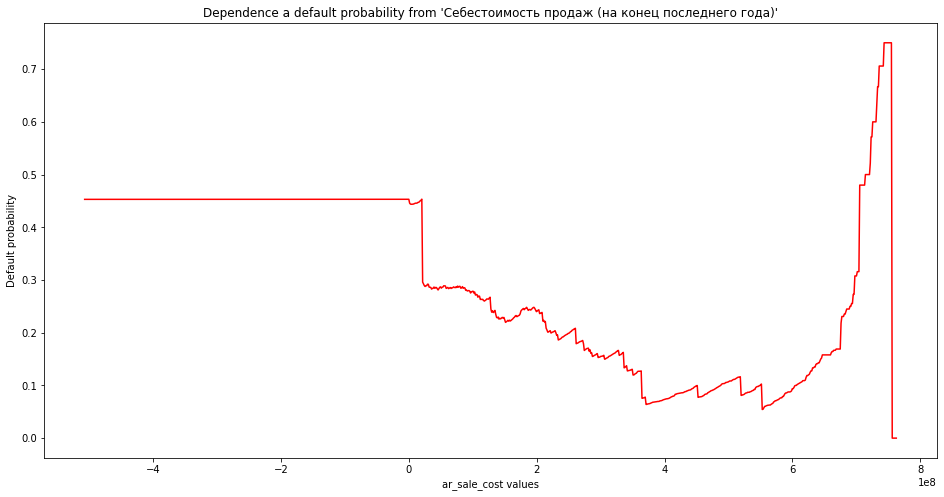

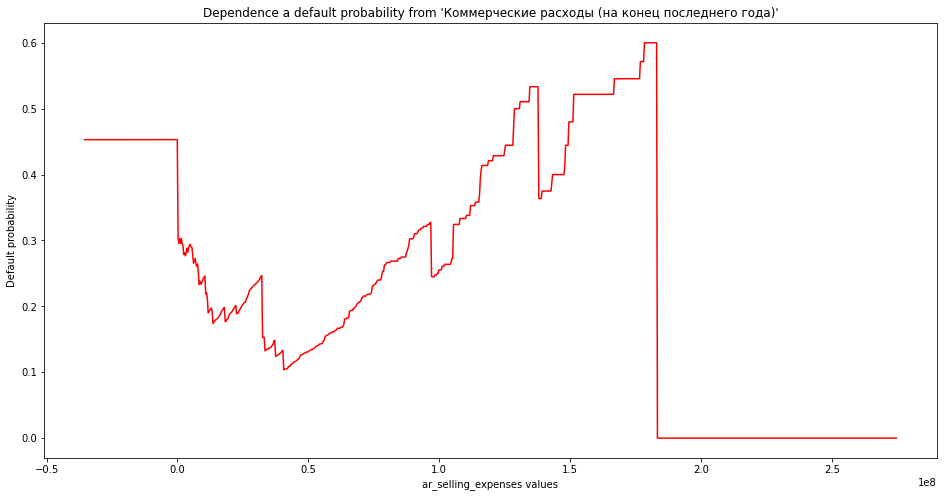

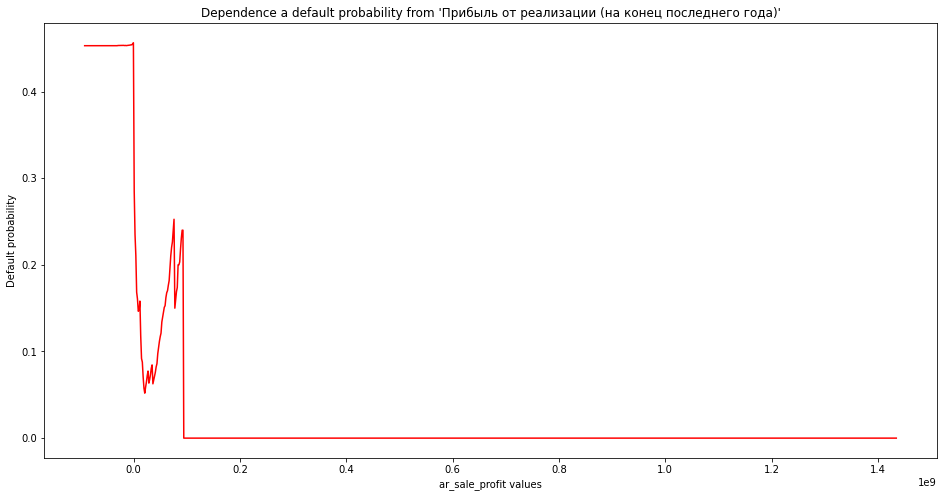

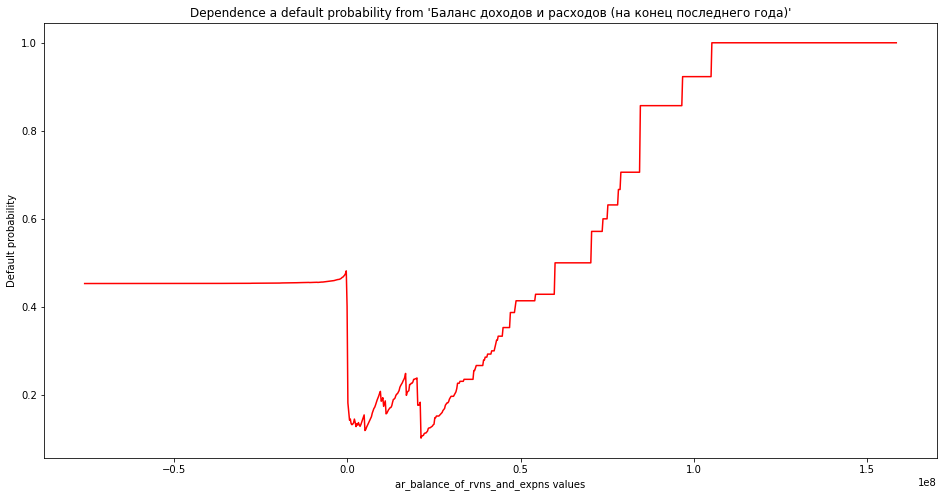

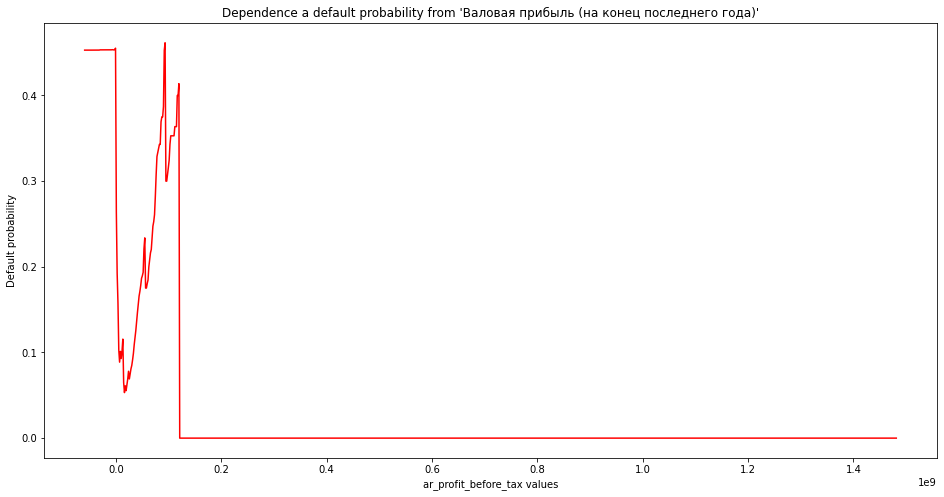

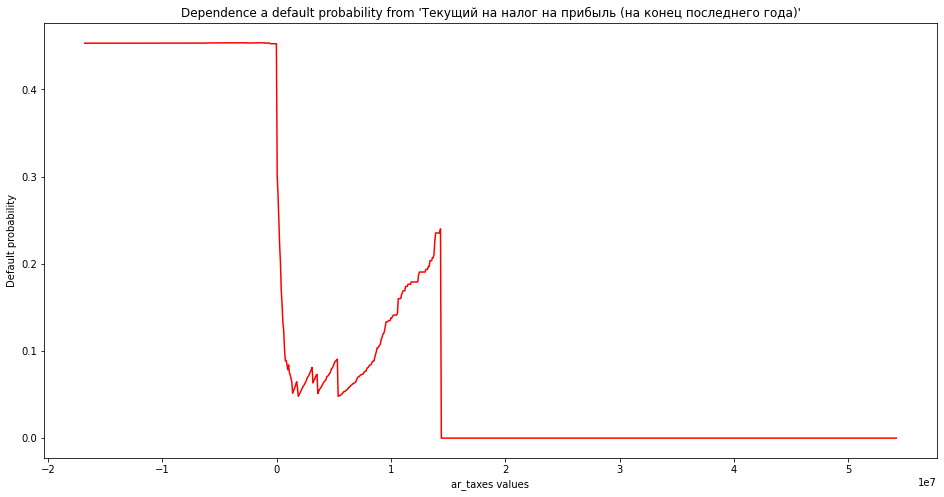

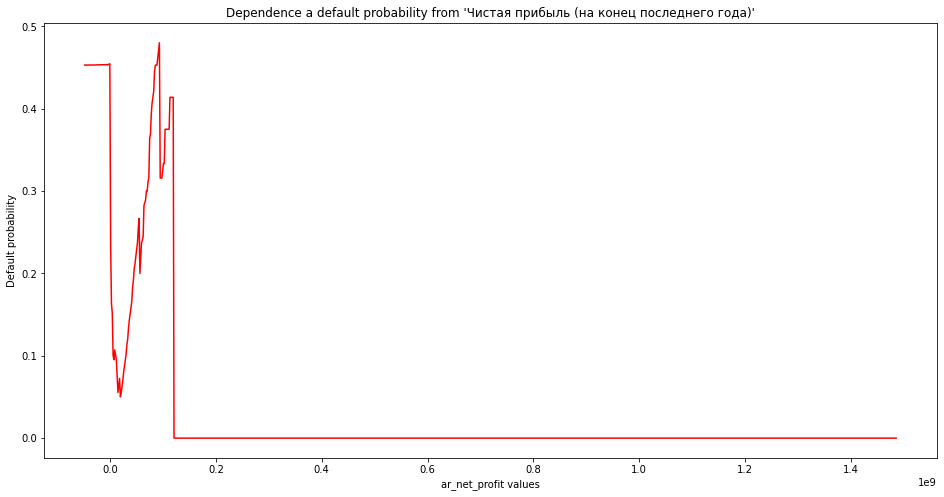

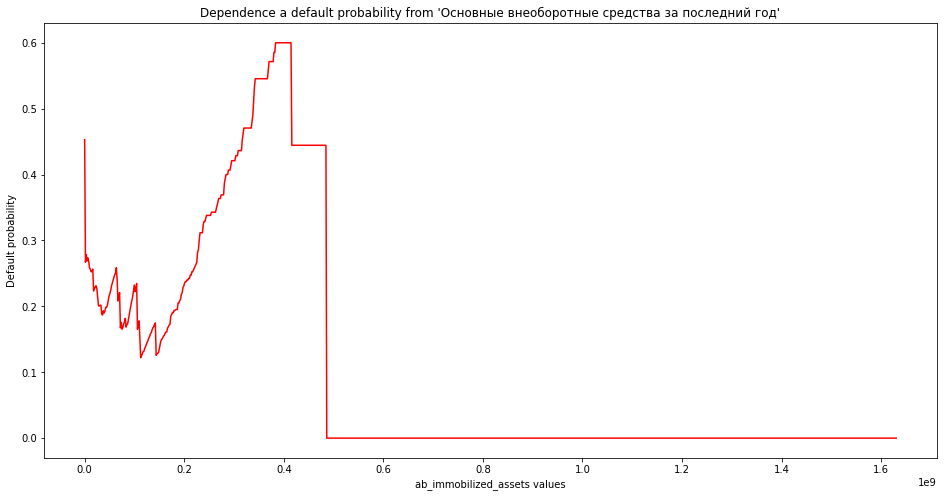

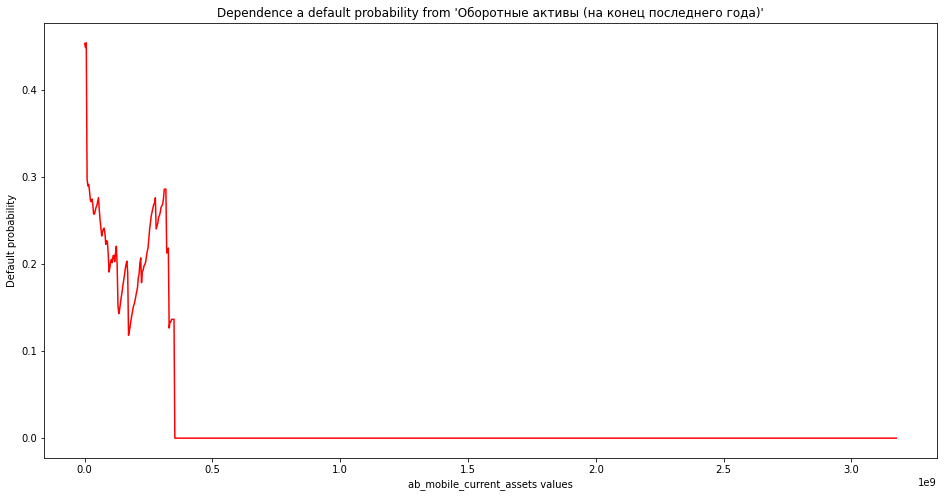

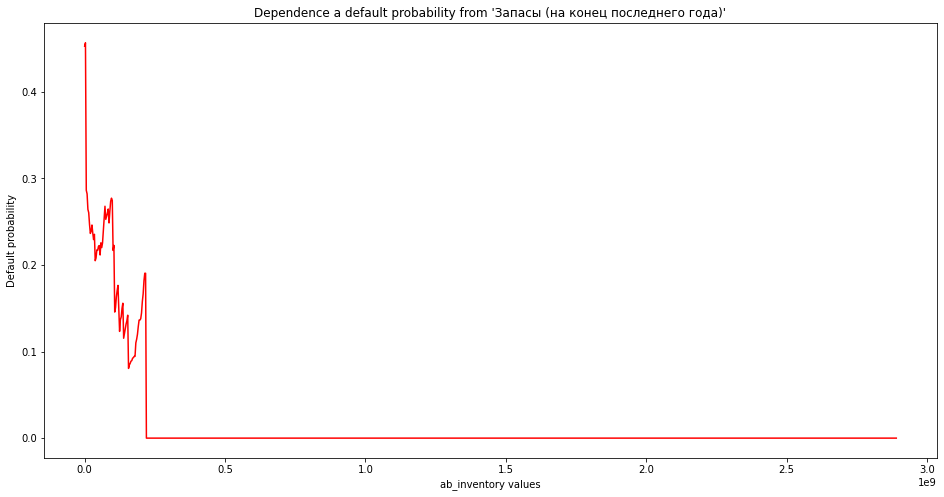

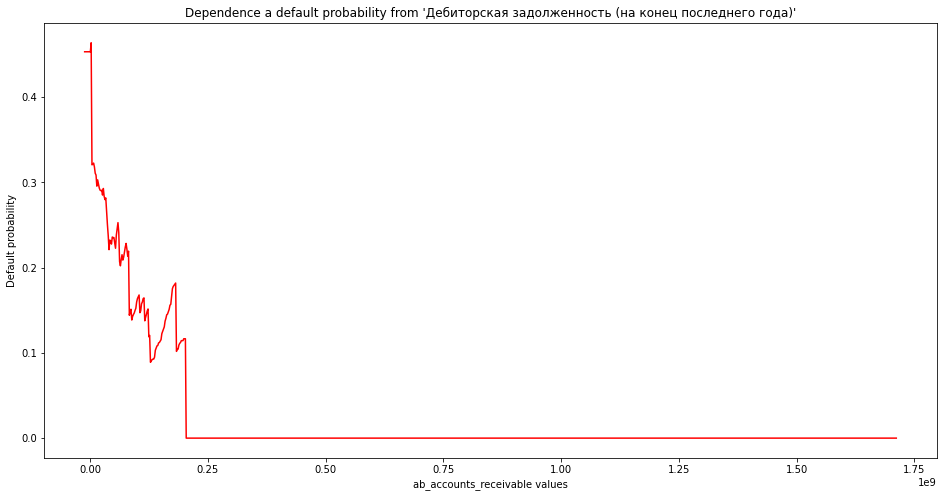

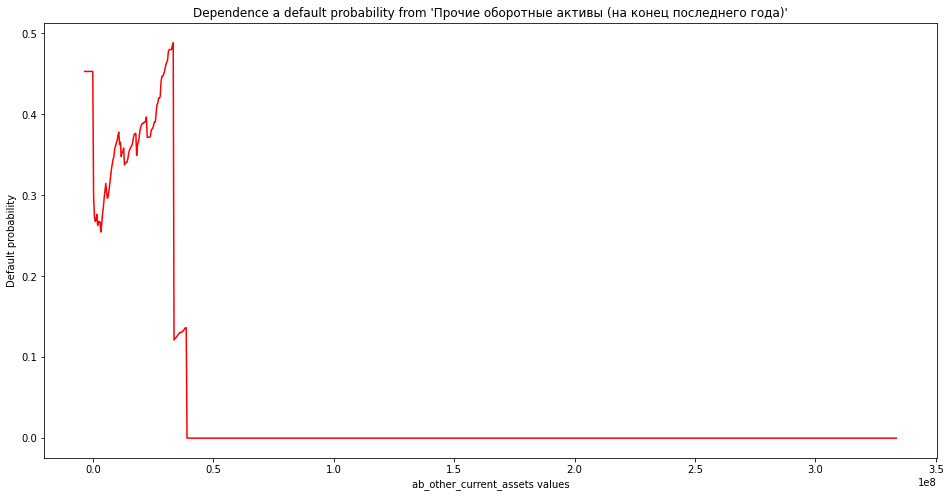

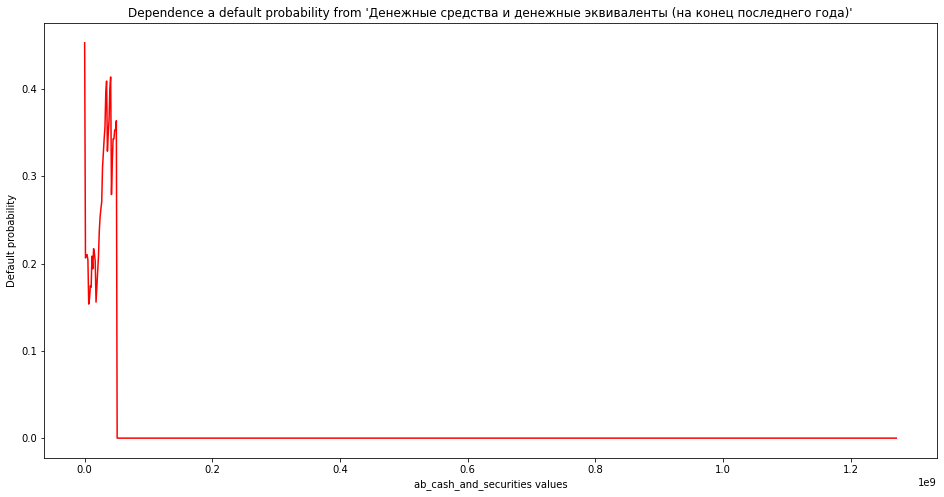

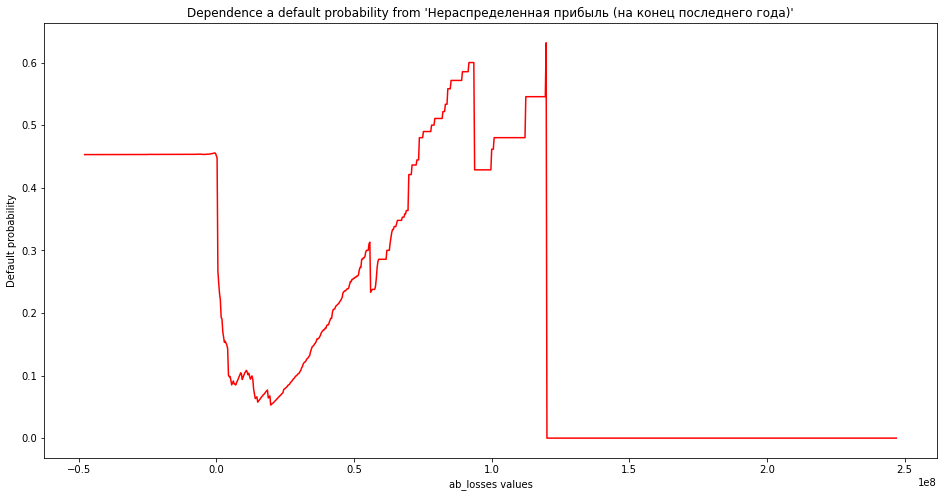

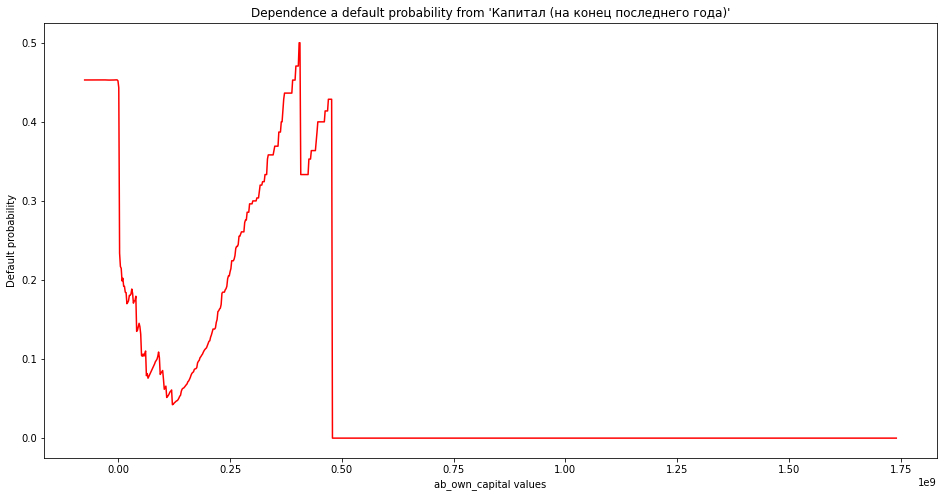

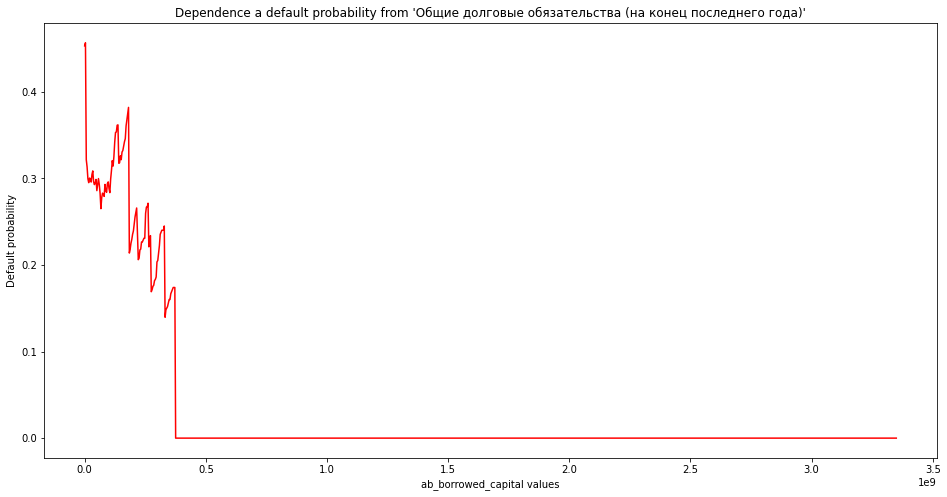

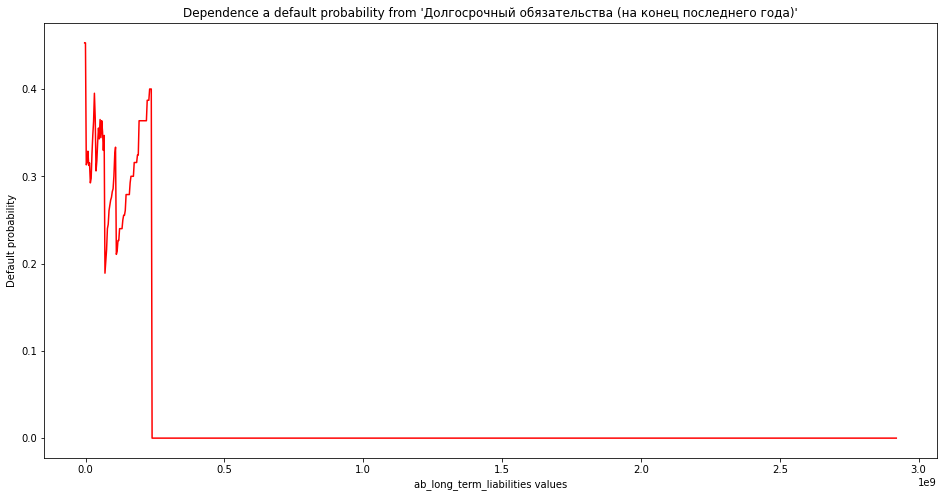

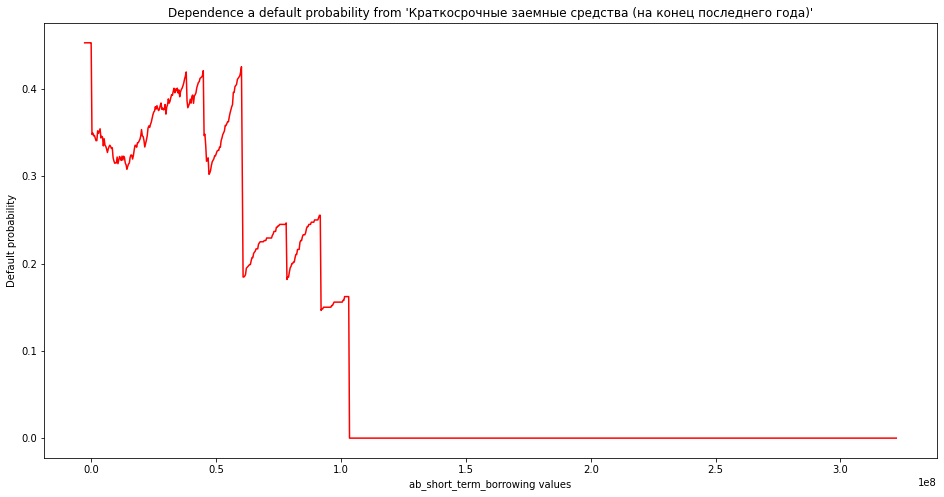

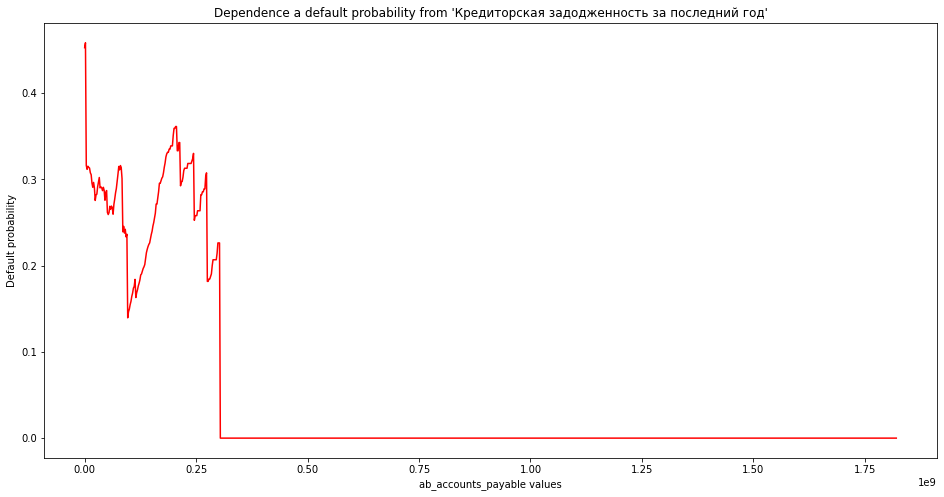

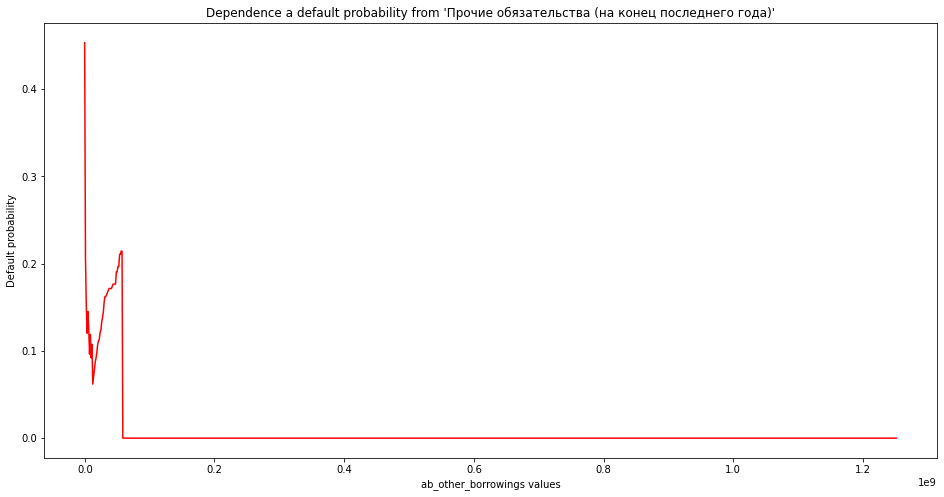

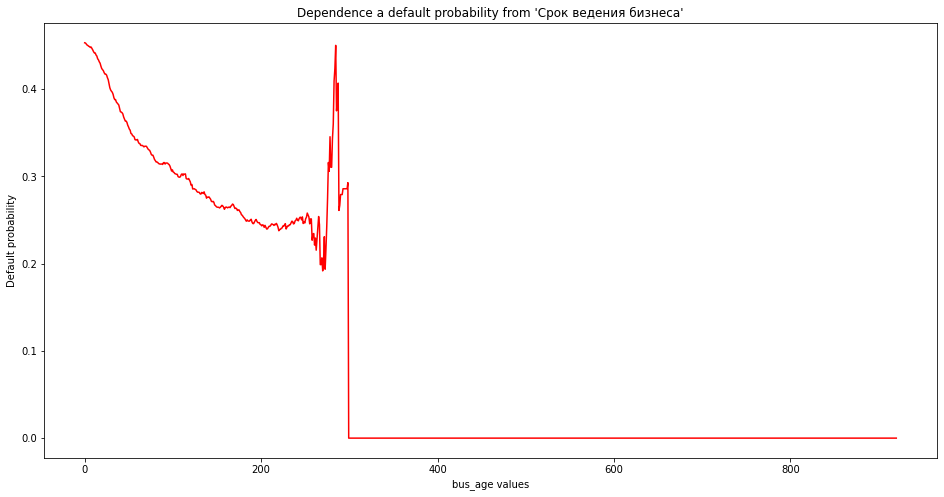

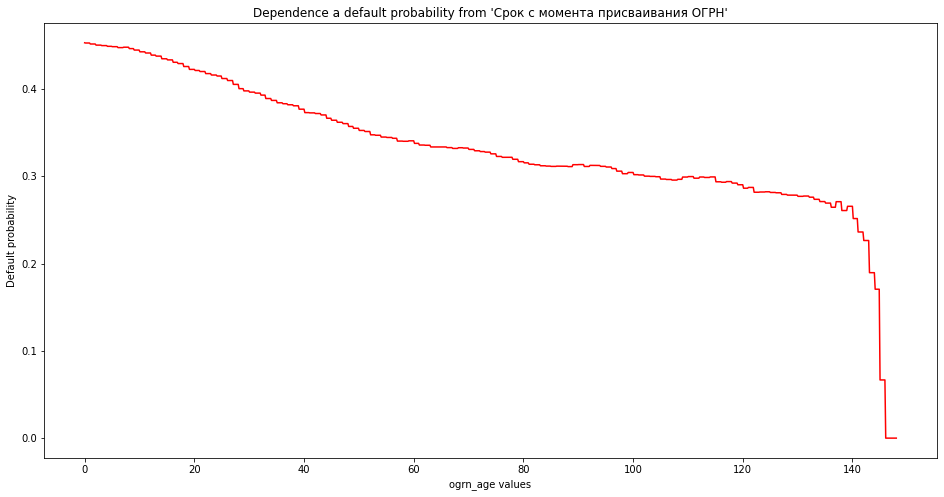

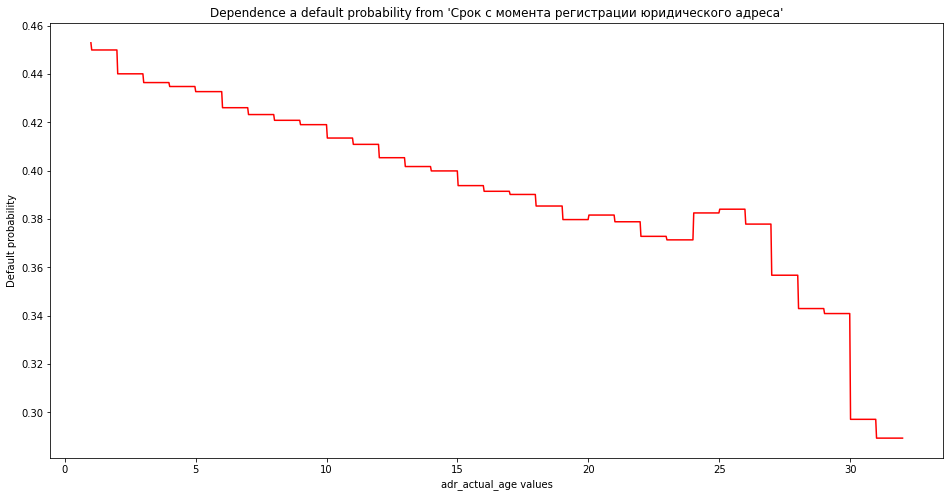

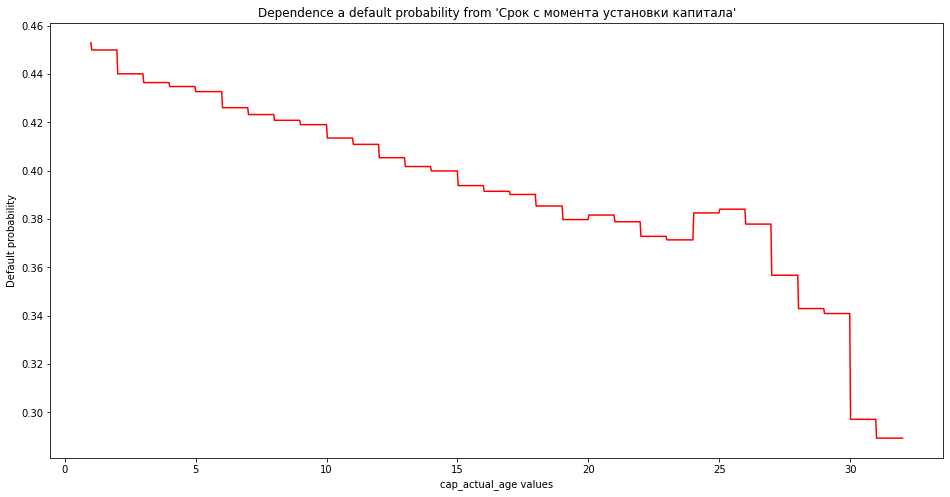

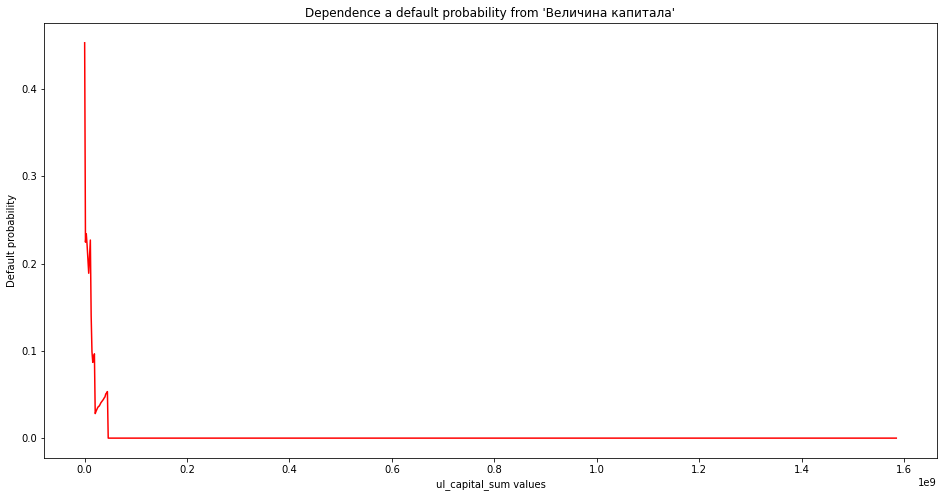

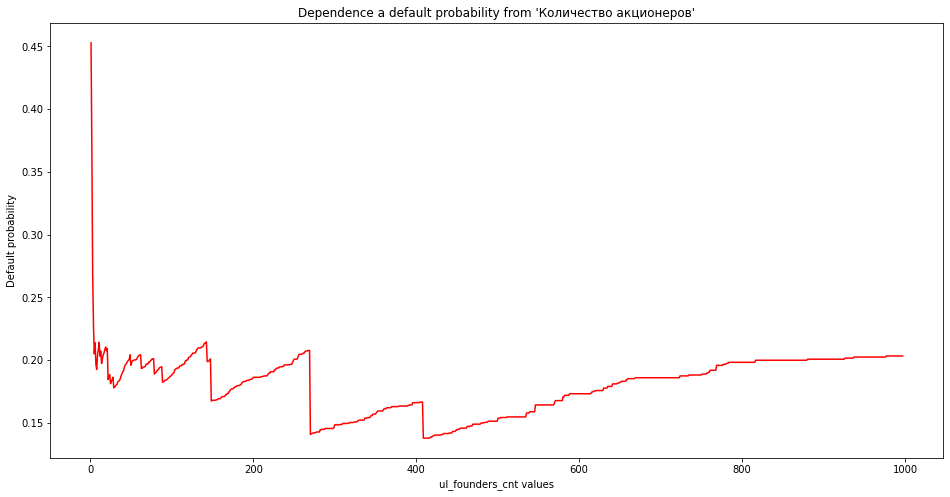

In [ ]:
for feature in cont_features:
  show_default_probs(feature)

Проанализировав графики, я постарался выделить фичи, для которых тренды наиболее просты

Однако после балансировки сделать это оказалось сложно. Я сохранил пару значений в smooth_features, но не факт, что это будет полезно

In [ ]:
smooth_features = ["ogrn_age", "cap_actual_age", "adr_actual_age", "ul_founders_cnt",
                   "ul_capital_sum", "ab_inventory", "ab_accounts_receivable"]

На мой взгляд, не так важны фичи типа выручки и стоимости продаж, как, например, количество запасов (чтобы выплатить долги в экстренном случае) или общие долговые обязательства (возможно, компания не вывезет, если их будет слишком много)

Отталкиваясь от подобных рассуждений, я попытался выдвинуть гипотезу о том, какие переменные могут оказаться полезными в нашей задаче, и это:  

1. Запасы
2. Общие долговые обязательства
3. Долгосрочные обязательства
4. Краткосрочные заемные средства
5. Кредиторская задолженность за последний год
6. Прочие обязательства
7. Баланс доходов и расходов 
8. Срок ведения бизнеса

In [ ]:
important_features = ["ar_balance_of_rvns_and_expns", "bus_age", "ab_inventory", "ab_borrowed_capital", 
                      "ab_other_borrowings", "ab_long_term_liabilities", "ab_short_term_borrowing", "ab_accounts_payable"]

In [ ]:
def show_dist(feature):
  plt.hist(train_df[feature], bins=20)
  try:
    rus_name = desc_df[desc_df.field == feature].desc_rus.values[0]
  except IndexError:
    rus_name = "Дефолт"
  plt.xlabel(f"value of {feature}")
  plt.ylabel("amount of samples with this value")
  plt.title(f"{rus_name} distribution")
  plt.rcParams["figure.figsize"] = (12, 6)
  plt.show()
  print(f"Unique values: {train_df[feature].nunique()}")

Посмотрим на распределения important_features

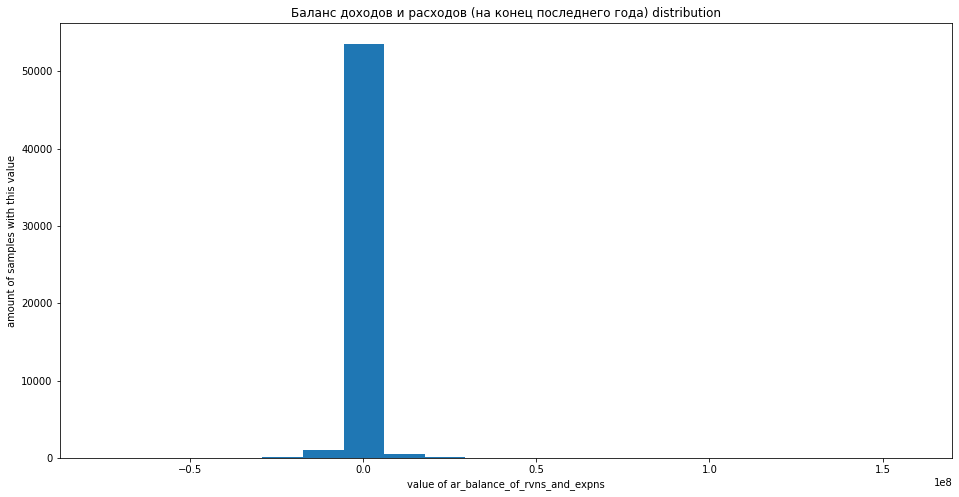

Unique values: 5064


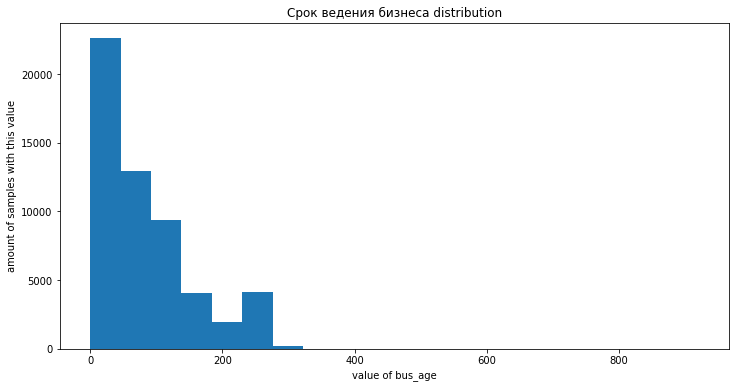

Unique values: 315


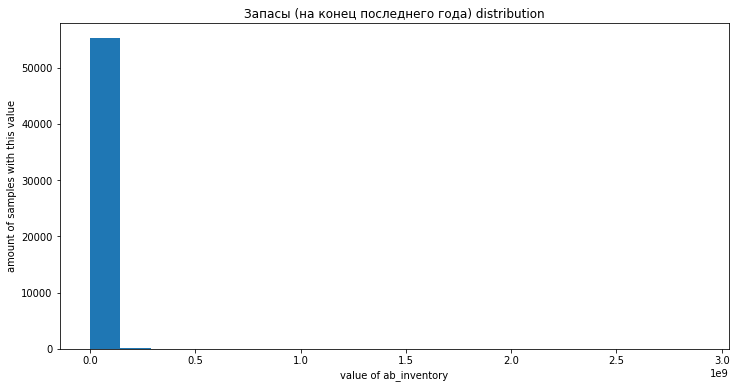

Unique values: 9144


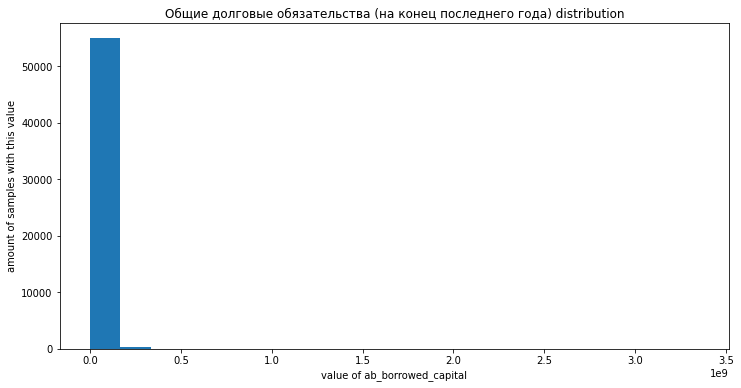

Unique values: 10263


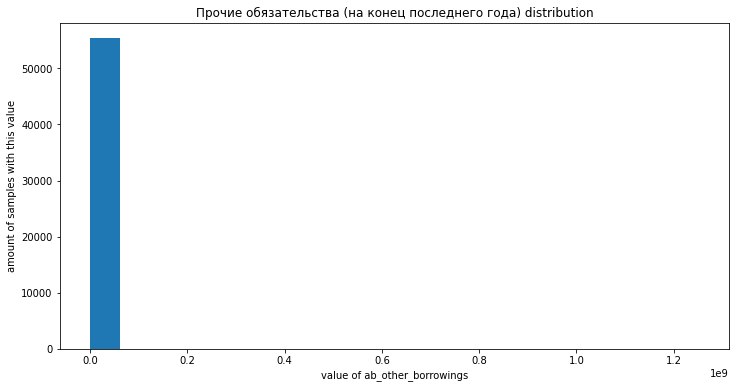

Unique values: 1437


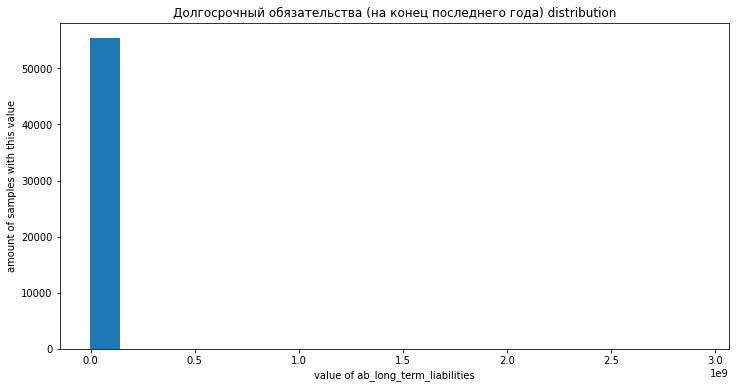

Unique values: 2295


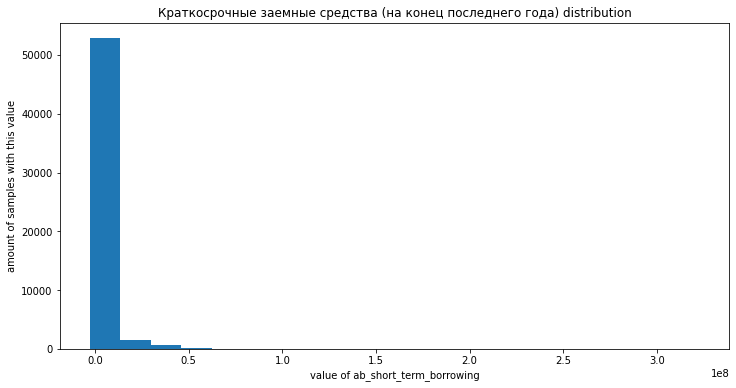

Unique values: 4898


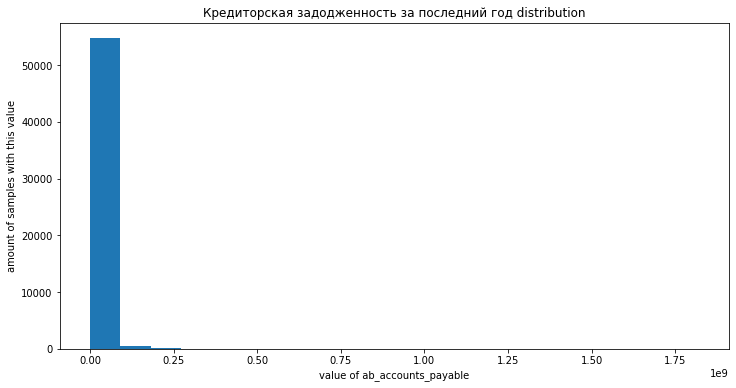

Unique values: 8799


In [ ]:
for feature in list(important_features):
  show_dist(feature)
  None

Сохраним фичи baseline модели, которая показала себя неплохо

In [ ]:
baseline = ["bus_age", "ul_capital_sum", "ul_founders_cnt"]

Уверен, что признак "Баланс расходов и доходов достаточно информативен", поэтому хочу ввести новый бинарный признак, равный по сути знаку этого баланса

В качестве доказательства его важность можно сделать небольшую сводную таблицу, которая показывает, что:

Часть компаний, которых постиг дефолт и у которых neg_balance положительный ~ 0.35

Часть компаний, которых постиг дефолт и у которых neg_balance отрицательный ~ 0.47


In [ ]:
train_df["neg_balance"] = (train_df['ar_balance_of_rvns_and_expns'] < 0).astype(int)
test_df["neg_balance"] = (test_df['ar_balance_of_rvns_and_expns'] < 0).astype(int)
cat_features.append("neg_balance")
train_df.groupby(["neg_balance"]).agg({"default_12m": ["sum", "count"]})

default_12m       
                    sum  count
neg_balance                   
0                  2712   7663
1                 22380  47733

Сохраним в new_baseline фичи исходного бейзлайна; те, на которые ставлю я; новоиспеченную фичу neg_balance и "трендовые" фичи



In [ ]:
new_baseline = baseline + important_features + smooth_features + ["neg_balance"]

### Продублируем train_df и test_df в нормализованном виде

Думаю, нормализация не повредит ни одному алгоритму (тем более линейным)

Решил не делать min-max стандартизацию

In [ ]:
def make_norm(dataset): 
  scaler = StandardScaler()

  norm_dataset = dataset.copy()
  norm_dataset[cont_features] = pd.DataFrame(scaler.fit_transform(dataset[cont_features]), columns=[cont_features])
  try:
    norm_dataset[TARGET] = dataset[TARGET]
  except:
    pass
  
  return norm_dataset

In [ ]:
norm_train_df = make_norm(train_df)
norm_test_df = make_norm(test_df)

Убедимся, что не возникло случайных пропусков



In [ ]:
assert norm_test_df.isna().sum().sum() + norm_train_df.isna().sum().sum() == 0

# 4. Полезные вспомогательные функции

 Функция для проверки метрик accuracy, f1_score, roc auc, cohen_kappa

In [ ]:
def get_metrics(model, data_to_pred, data_to_comp, see):
  thresh = data_to_comp.mean()
  preds = (model.predict_proba(data_to_pred)[:, 1] > thresh).astype(int)
  accuracy = accuracy_score(data_to_comp, preds)
  roc_auc = roc_auc_score(data_to_comp, preds)
  f_score = f1_score(data_to_comp, preds)
  kappa = cohen_kappa_score(data_to_comp, preds)
  if see:
    print(f"accuracy: {accuracy}")
    print(f"f1_score: {f_score}")
    print(f"roc auc score: {roc_auc}")
    print(f"kappa: {kappa}")

  return [accuracy, f_score, roc_auc, kappa]

### Про метрики

Для валидации я выбрал метрики accuracy (количество верно данных предсказаний), f1_score, roc_auc_score и cohen's kappa

По какой из них выбирать лучшую модель я однозначно не решил и старался анализировать все значения

Функция для обучения и валидации модели с заданными параметрами

Данные для обучения и валидации указываются в явном виде

In [ ]:
def train_and_see_metrics(model, X_train, X_test, y_train, y_test, see=False):
  model.fit(X_train, y_train)
  return get_metrics(model, X_test, y_test, see)

функция для предсказания целевых переменных в test_df 


In [ ]:
def make_preds(model, data_to_pred, thresh=0.5):
  preds = (model.predict_proba(data_to_pred)[:, 1] > thresh).astype(int)
  return preds

Функция для записи предсказания в файл для сабмита

Можем записывать уже имеющиеся данные, а можем внутри функции попросить обученную модель сделать предсказания по определенному набору



In [ ]:
def make_file(file_name, preds=None, data_to_pred=None, model=None, write_file=True, thresh=0.5):
  if preds is None:
    preds = (model.predict_proba(data_to_pred)[:, 1] > thresh).astype(int)
  
  answ_df = test_df[['record_id']]
  answ_df['id'] = answ_df['record_id']
  answ_df.drop('record_id', axis=1, inplace=True)
  answ_df['predict'] = preds

  if write_file:
    answ_df.to_csv(f'{file_name}.csv', index=False, sep=';')

# 5. Обучаем модели

In [ ]:
from sklearn.model_selection import GridSearchCV

Создадим датасеты для тренировки и валидации в обычном и нормализированном видах

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_df.drop("default_12m", axis=1),
                                                    train_df['default_12m'], stratify=train_df['default_12m'],
                                                    random_state=42, shuffle=True, test_size=0.2)

In [ ]:
X_train_norm, X_test_norm= train_test_split(norm_train_df.drop("default_12m", axis=1), stratify=train_df['default_12m'],
                                            random_state=42, shuffle=True, test_size=0.2)

Сохраним комбинации различных наборов данных, которые я выделил в пункте Feature_exploring

In [ ]:
combinations = {"full": list(train_df)[1:-2], "new_baseline": list(set(new_baseline)), "baseline": baseline, "smooth": smooth_features, "important": important_features,
                "baseline + smooth": list(set(baseline + smooth_features)), "baseline + important": list(set(baseline + important_features)), 
                "important + smooth": list(set(smooth_features + important_features)), "inform": inf_features}

### Функция, которая будет работать вместо нас

Напишем функцию, которая будет принимать модель, обучать ее на различных данных

В качестве отбора результата она использует коэффициент баланса предсказаний 

Это по-читерски. Это нужно переписать

In [ ]:
def research_features(model):
  results = {}
  metrics_names = ["accuracy", "roc auc", "f1_score", "kappa"]
  with_norm = True
  best_coeff = 1
  best_preds = None
  best_combo = None
  for combo_name, combo in combinations.items():
    results[combo_name + " + norm"] = [None, None]
    metrics_values = train_and_see_metrics(model, X_train[combo], X_test[combo], y_train, y_test, see=False)
    results[combo_name + " + norm"][0] = dict(zip(metrics_names, metrics_values)) 
    preds = make_preds(model, test_df[combo])
    results[combo_name + " + norm"][1] = preds
    coeff = preds.mean()
    if abs(0.5 - coeff) < abs(0.5 - best_coeff):
      best_combo = combo_name
      best_preds = preds  
      best_coeff = coeff

  for combo_name, combo in combinations.items():
    results[combo_name] = [None, None]
    metrics_values = train_and_see_metrics(model, X_train_norm[combo], X_test_norm[combo], y_train, y_test, see=False)
    results[combo_name][0] = dict(zip(metrics_names, metrics_values)) 
    preds = make_preds(model, test_df[combo])
    results[combo_name][1] = preds 
    coeff = preds.mean()
    if abs(0.5 - coeff) < abs(0.5 - best_coeff):
      best_combo = combo_name
      with_norm = False
      best_preds = preds
      best_coeff = coeff

  return best_preds, best_combo, with_norm, results

In [ ]:
def show_best_combo(combo, norm):
  print(f"The best combo: {combo}")
  if norm:
    print("With data normalization!")
  else:
    print("With out data normalization!")

In [ ]:
def show_results(res):
  for features_comb, values in res.items():
    print(f"Combination: {features_comb}")
    print("Metrics:")
    for metric_name, metric_value in values[0].items():
      print(f"{metric_name}: {metric_value}")
    print(f"Balance coeff: {values[1].mean()}")
    print("_" * 100)

### Логистическая регрессия

In [ ]:
base_reg = LogisticRegression(random_state=42, max_iter=10000)

best_reg_preds, best_reg_combo, with_norm, reg_results = research_features(base_reg)

In [ ]:
show_best_combo(best_reg_combo, with_norm)

The best combo: new_baseline
With data normalization!


In [ ]:
best_reg_preds.mean()

0.58

In [ ]:
show_results(reg_results)

Лучшее, что я смог сделать с помощью логистической регрессии - набрать accuracy 0.6 baseline-моделью

### Дерево

In [ ]:
from sklearn.tree import DecisionTreeClassifier

Для начала обучим дерево на всем наборе данных  **(нужно сделать grit_search внутри explore_features)** и отдадим лучшее дерево в exploring_features

In [ ]:
params = {"max_depth": [3, 4, 5], "min_samples_split": [50, 100, 200], "min_samples_leaf": [50, 100, 200]}
grid = GridSearchCV(DecisionTreeClassifier(random_state=42), params, scoring='roc_auc', n_jobs=-1)

grid.fit(train_df.drop("default_12m", axis=1), train_df["default_12m"])

GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=42,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5],
                         'min_

In [ ]:
my_tree = grid.best_estimator_

tree_best_preds, tree_best_combo, with_norm, tree_results = research_features(my_tree)

Лучший результат, который я выбил деревом - 0.62

In [ ]:
tree_best_preds.mean()

0.515

In [ ]:
show_best_combo(tree_best_combo, with_norm)

The best combo: baseline
With data normalization!


In [ ]:
show_results(tree_results)

Combination: full + norm
Metrics:
accuracy: 0.6534296028880866
roc auc: 0.6260954235637779
f1_score: 0.6523238422258082
kappa: 0.30344198268879663
Balance coeff: 0.38
____________________________________________________________________________________________________
Combination: new_baseline + norm
Metrics:
accuracy: 0.6479241877256318
roc auc: 0.6378910238559362
f1_score: 0.6510766922684396
kappa: 0.29839710257677354
Balance coeff: 0.56
____________________________________________________________________________________________________
Combination: baseline + norm
Metrics:
accuracy: 0.6499097472924188
roc auc: 0.6235077161991652
f1_score: 0.6490551709476601
kappa: 0.2967634506507969
Balance coeff: 0.515
____________________________________________________________________________________________________
Combination: smooth + norm
Metrics:
accuracy: 0.6523465703971119
roc auc: 0.6388524282767674
f1_score: 0.6546222523031521
kappa: 0.3059537787113795
Balance coeff: 0.46
________________

Сделаем submission лучшим деревом

In [ ]:
make_file("final_tree", tree_best_preds)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

***Решая задание, я столкнулся с большой проблемой:***

Запуская один и ту же функцию после нового открытия ноутбука (в моем случае research_features), она выдавала мне разные результаты своей работы. Не понимаю, где я ошибся - random_state я фиксировал, в самой функции случайностей быть не должно. Работать так невероятно трудно. В том числе я, кажется, утратил ту модель, которая дала мне лучший результат. Необходимо научиться работать без таких факапов. Буду рад получить фидбек по этому поводу (может, я действительно забыл где-то условные random_state) 

Исходя из этого, ячейки, в которых я "делаю сабмит лучшей моделью" могут быть невопроизводимы(

Однако я надеюсь, что вы поверите в честность выполнения работы, потому что вручную заполнять нолики и единички в excel-файле - это уж совсем не серьезно,  и я в этом не заинтересован

### Модификация research_features

Перепишем функцию research_features, чтобы каждый раз она вызывала grid_search с каждой из комбинаций данных, а затем запоминала лучшие параметры модели и набор данных

Изначально model передается пустой

Выберем roc_auc в качестве метрики отбора лучшей модели в GridSearchCV (for a while)

In [ ]:
def grid_train_and_see_metrics(model, X_train, X_test, y_train, y_test, params, see=False):
  grid = GridSearchCV(model, params, scoring="roc_auc", n_jobs=-1, refit=True)
  grid.fit(X_train, y_train)
  model_params = grid.best_params_
  best_model = grid.best_estimator_
  return get_metrics(best_model, X_test, y_test, see), best_model

Во время использования research_features я пришел к небольшому внутреннему диссонансу:

1. Я осознаю, что выбирать лучшую модель по пропорции данных ей предсказаний - это бред, который не поможет решить задачу в проде

2. Когда я устанавливаю в качестве поиска лучшего алгоритма какую-либо метрику, порой получаю супер несбалансированный прогноз модели. Не могу доверять этому, потому что количество моих попыток ограничено

Было решено переписать функцию в том числе так, чтобы она не выдавала "лучшую" модель, а просто сохраняла данные. ***Финальное решение, в конце концов, на человеке, а не алгоритме***

In [ ]:
def research_with_grid(model, grid_params):
  num_combo = 1
  results = {}
  metrics_names = ["accuracy", "roc auc", "f1_score", "kappa"]

  for combo_name, combo in combinations.items():
    print(num_combo)
    results[combo_name + " + norm"] = [None, None, None]
    metrics_values, model = grid_train_and_see_metrics(model, X_train[combo], X_test[combo], y_train, y_test, grid_params, see=False)
    results[combo_name + " + norm"][0] = dict(zip(metrics_names, metrics_values)) 
    results[combo_name + " + norm"][1] = model
    preds = make_preds(model, test_df[combo])
    results[combo_name + " + norm"][2] = preds
    num_combo += 1

  for combo_name, combo in combinations.items():
    print(num_combo)
    results[combo_name] = [None, None, None]
    metrics_values, model = grid_train_and_see_metrics(model, X_train_norm[combo], X_test_norm[combo], y_train, y_test, grid_params, see=False)
    results[combo_name][0] = dict(zip(metrics_names, metrics_values)) 
    results[combo_name][1] = model
    preds = make_preds(model, test_df[combo])
    results[combo_name][2] = preds 
    num_combo += 1

  return results

Потестимся с деревом

In [ ]:
base_tree = DecisionTreeClassifier(random_state=42)

base_params = {"max_depth": [4, 5, 6], "min_samples_split": [25, 50, 75], "min_samples_leaf": [20, 100, 200]}

Перезапишем то, что мы получили ранее

In [ ]:
tree_results = research_with_grid(base_tree, base_params)

Немного модифицируем show_results под новую функцию-исследователя и посмотрим на результаты

In [ ]:
def grid_show_results(res):
  for features_comb, values in res.items():
    print(f"Combination: {features_comb}")
    print("Metrics:")
    for metric_name, metric_value in values[0].items():
      print(f"{metric_name}: {metric_value}")
    print(f"Balance coeff: {values[2].mean()}")
    print("_" * 100)

In [ ]:
grid_show_results(tree_results)

Combination: full + norm
Metrics:
accuracy: 0.6366425992779784
roc auc: 0.6705940108001963
f1_score: 0.6521028045908636
kappa: 0.29323709536557463
Balance coeff: 0.305
____________________________________________________________________________________________________
Combination: new_baseline + norm
Metrics:
accuracy: 0.6403429602888087
roc auc: 0.6318706697459584
f1_score: 0.6438731138782016
kappa: 0.283919338015022
Balance coeff: 0.51
____________________________________________________________________________________________________
Combination: baseline + norm
Metrics:
accuracy: 0.6368231046931407
roc auc: 0.6086364520521299
f1_score: 0.6356719240027641
kappa: 0.2702146374196356
Balance coeff: 0.5
____________________________________________________________________________________________________
Combination: smooth + norm
Metrics:
accuracy: 0.6379963898916967
roc auc: 0.6392661210540516
f1_score: 0.644023244585934
kappa: 0.2828105150635696
Balance coeff: 0.515
___________________

### Рандомный лес

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
forest_params = {"n_estimators": [100, 300, 500], "max_depth": [4, 5, 6]}
base_forest = RandomForestClassifier(random_state=42)

In [ ]:
forest_results = research_with_grid(base_forest, forest_params)

Взглянем на результат работы

In [ ]:
grid_show_results(forest_results)

Combination: full + norm
Metrics:
accuracy: 0.6713898916967509
roc auc: 0.6655644346468265
f1_score: 0.6757280098371609
kappa: 0.3464188629251148
Balance coeff: 0.305
____________________________________________________________________________________________________
Combination: new_baseline + norm
Metrics:
accuracy: 0.6620938628158844
roc auc: 0.6475240067783846
f1_score: 0.6640797308127153
kappa: 0.3249096980600743
Balance coeff: 0.4
____________________________________________________________________________________________________
Combination: baseline + norm
Metrics:
accuracy: 0.6402527075812274
roc auc: 0.6121813582409029
f1_score: 0.6390978758526542
kappa: 0.277056927997097
Balance coeff: 0.46
____________________________________________________________________________________________________
Combination: smooth + norm
Metrics:
accuracy: 0.6532490974729241
roc auc: 0.6376155442369364
f1_score: 0.6549847750631416
kappa: 0.3070040398185805
Balance coeff: 0.32
____________________

Напишем функцию, которая будет возвращать предобученную модель и ее предсказания по названию комбинации

In [ ]:
def get_model_and_preds_by_combo(results, combo):
  values = results[combo]
  model, preds = values[1], values[2]

  return model, preds

Глядя на результаты, попытаюсь соблюсти грань между значениями метрик и балансом предсказания

In [ ]:
my_forest, forest_predictions = get_model_and_preds_by_combo(forest_results, "new_baseline + norm")

In [ ]:
make_file("nbl_n_forest", forest_predictions)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

 ***Проблемка***

Где-то в моем коде косяк - предсказания модели, которую возвращает функция, не соответсвуют предсказаниям, которые, опять же, вернула функция

In [ ]:
assert (my_forest.predict(norm_test_df[new_baseline]) == forest_predictions).sum() == 200, "I'm already exhausted of it..."

Очень прошу указать мне на мою ошибку, потому что работать в таком режиме отвратительно (а ведь только-только пошли улучшения), чтобы в будущем я мог быть эффективнее 

У меня есть гипотеза - записывать модели в файл с помощью pickle. Делать это, судя по всему, имеет смысл прямо во время обучения моделей в train_and_see_metrics, чтобы потом можно было считать любой алгоритм из файла

### Градиентный бустинг

Из прошлого опыта можно сделать вывод, что обучаться без нормализации - плохая идея, поэтому исключим из функции эту часть, чтобы ускорить обучение

In [ ]:
def boost_with_grid(model, grid_params):
  num_combo = 1
  results = {}
  metrics_names = ["accuracy", "roc auc", "f1_score", "kappa"]

  for combo_name, combo in combinations.items():
    print(num_combo)
    results[combo_name + " + norm"] = [None, None, None]
    metrics_values, model = grid_train_and_see_metrics(model, X_train[combo], X_test[combo], y_train, y_test, grid_params, see=False)
    results[combo_name + " + norm"][0] = dict(zip(metrics_names, metrics_values)) 
    results[combo_name + " + norm"][1] = model
    preds = make_preds(model, test_df[combo])
    results[combo_name + " + norm"][2] = preds
    num_combo += 1

  return results

In [ ]:
from xgboost import XGBClassifier

In [ ]:
boost_params = {'learning_rate': [0.05, 0.01], 'n_estimators': [300, 500]}
base_boost = XGBClassifier(random_state=42, n_jobs=-1)

In [ ]:
boost_results = boost_with_grid(base_boost, boost_params)

1
2
3
4
5
6
7
8
9


Посмотрим на результаты

In [ ]:
grid_show_results(boost_results)

Combination: full + norm
Metrics:
accuracy: 0.7188628158844765
roc auc: 0.7204021183017683
f1_score: 0.7257996416126556
kappa: 0.44322635567966806
Balance coeff: 0.33
____________________________________________________________________________________________________
Combination: new_baseline + norm
Metrics:
accuracy: 0.7093862815884476
roc auc: 0.7078039927404718
f1_score: 0.7152023761611502
kappa: 0.423285713810013
Balance coeff: 0.39
____________________________________________________________________________________________________
Combination: baseline + norm
Metrics:
accuracy: 0.6685920577617328
roc auc: 0.656822429906542
f1_score: 0.6713038547891876
kappa: 0.33876679132864385
Balance coeff: 0.46
____________________________________________________________________________________________________
Combination: smooth + norm
Metrics:
accuracy: 0.7022563176895307
roc auc: 0.693714604029338
f1_score: 0.7058765044587703
kappa: 0.4066479726740283
Balance coeff: 0.395
___________________

Постаравшись выдержать грань между "хорошие метрики" и "адекватный баланс предсказаний", хочу сделать последние сабмиты предсказаниями моделей, обученных на комбинациях:     

1. new_baseline + norm

2. inform + norm

3. baseline + important + norm

In [ ]:
combinations_to_sub = ["new_baseline + norm", "inform + norm", "baseline + important + norm"]

predictions_to_sub = {combo_name: None for combo_name in combinations_to_sub}

for combo in combinations_to_sub:
  _, preds = get_model_and_preds_by_combo(boost_results, combo)  
  print(preds.mean())
  make_file(combo.replace(" + ", "_") + "_boost", preds)

0.39
0.305
0.46


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

Уверен, что при должной усидчивости и настойчивости градиентный бустинг может стать X-фактором. Вероятно, результат вышел слабым из-за того, что я не поставил в grid ограничение на глубину деревьев и алгоритмы переобучались

# Выводы

0. Нужно ближе подружиться с градиентным бустингом

1. Это было непросто для меня, но не из-за какой-то лютой задачи (задаче вполне себе окей), а из-за моих глупых ошибок и текущей неопытности

2. Это было невероятно полезно для меня. Я осознал большое количество слабых мест в своей работе и понял, насколько важно чаще практиковаться. Я переделывал и переписывал много функций, использовал разные методы. Я бы показал больше своих теоретических знаний на практике, но побоялся закопаться и просто не успеть к дедлайну. Хотя и в теории иногда чувствовал пробелы. Буду стремиться исправлять это

3. Работа измотала эмоционально, потому что к каждому провальному сабмиту я относился очень трепетно. Мне стоит быть более хладнокровным и мыслить еще более критически

4. Я супер благодарен за такую возможность и хочу вынести из этой задачи максимум пользы. Буду ждать фидбека! Особенно по части воспроизводимости результатов

![](https://drive.google.com/uc?export=view&id=1daqtc5txf17b1DHs2PYEYKdm-vGrt7dH)


# Спасибо за просмотр. Хорошего дня :3